# Subsampling verschieden langer Zeitreihen

Test SVM-Klassifikation

In [41]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn import model_selection, svm, metrics, manifold
import joblib

import prepare

In [12]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER

In [13]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [14]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [15]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [16]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train.shape, versuche_test.shape

((480, 5), (120, 5))

Abschneiden auf 800 ms, Subsampling auf 10 Punkte

In [17]:
subsample2 = prepare.Subsample2(10)
subsample2.fit() # dummy

Subsample2(subsample=10)

In [18]:
X_train = subsample2.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)
print(X_train.max(axis=(0,1)))
#festigkeit_train

(480, 10, 3) (480,)
[3600.84   623.066    4.08 ]


In [19]:
X_test = subsample2.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 10, 3)
[3498.34   621.113    3.75 ]


Skalieren Trainingsdaten

In [20]:
tsMaxScale = prepare.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train)

Skalieren Testdaten

In [21]:
X_test_scaled = tsMaxScale.transform(X_test)

In [22]:
def class_curves(X, ax, y, field):
    color = ['black', 'blue', 'red', 'green', 'cyan']
    ti = np.arange(0, X.shape[1]) # Zeitschritte
    for i in range(X.shape[0]):
        #print(X[i,:,ax])
        plt.plot(ti, X[i,:,ax], c=color[y[i]], linewidth=0.5, alpha=0.5)
    handles = [
        matplotlib.lines.Line2D([0], [0], color='black', label='ok'),
        matplotlib.lines.Line2D([0], [0], color='blue', label='ok_wechsel'),
        matplotlib.lines.Line2D([0], [0], color='red', label='oel'),
        matplotlib.lines.Line2D([0], [0], color='green', label='leitung'),
        matplotlib.lines.Line2D([0], [0], color='cyan', label='termin'),
    ]
    plt.legend(handles=handles)

Anzeige Kurven zur Kontrolle.

Text(0.5, 1.0, 'Komplette Kurve auf 10 Zeitpunkte in gleichem Abstand approximiert')

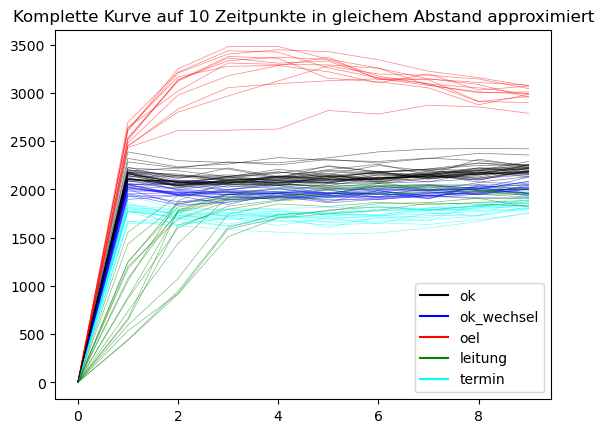

In [23]:
class_curves(X_train[:100,:,:], 0, label_train[:100], 'power')
plt.title("Komplette Kurve auf 10 Zeitpunkte in gleichem Abstand approximiert")

Kontrollanzeige t-SNE

In [24]:
X_train_projected = manifold.TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train_scaled[:,:,0])

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

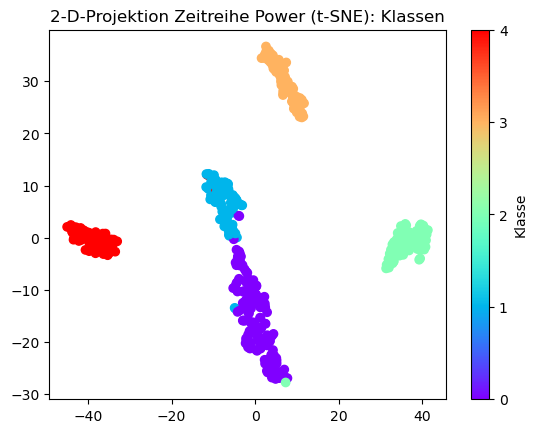

In [25]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=label_train, cmap='rainbow')
plt.colorbar(label='Klasse', ticks=[0,1,2,3,4,5])
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

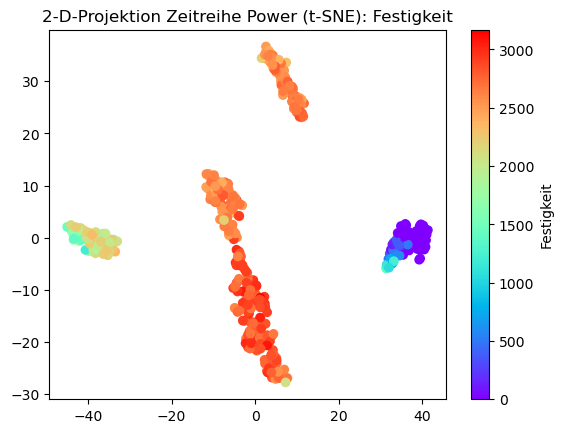

In [26]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=festigkeit_train, cmap='rainbow')
plt.colorbar(label='Festigkeit')
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

SVM kann nur 2-D-Daten: Flatten

Alternativ: nur Power verwenden (hier bessere Ergebnisse)

In [27]:
dims = X_train.shape
#X2_train = X_train_scaled.reshape(-1, dims[1]*dims[2])
#X2_test = X_test_scaled.reshape(-1, dims[1]*dims[2])
X2_train = X_train_scaled[:,:,0]
X2_test = X_test_scaled[:,:,0]

Kernel-SVM (Klassifikation) mit Standard-Parametern

In [28]:
estimator = svm.SVC()
_ = estimator.fit(X2_train, label_train)

Accuracy

In [29]:
score_train = estimator.score(X2_train, label_train)
score_test = estimator.score(X2_test, label_test)
score_train, score_test

(0.9770833333333333, 0.9666666666666667)

Anzeige Confusion Matrix (Testdaten)

In [30]:
def plot_confusion(y_true, y_pred):
    conf = metrics.confusion_matrix(y_true, y_pred)
    sns.heatmap(conf, annot=True)
    plt.xlabel('predict')
    plt.ylabel('truth')

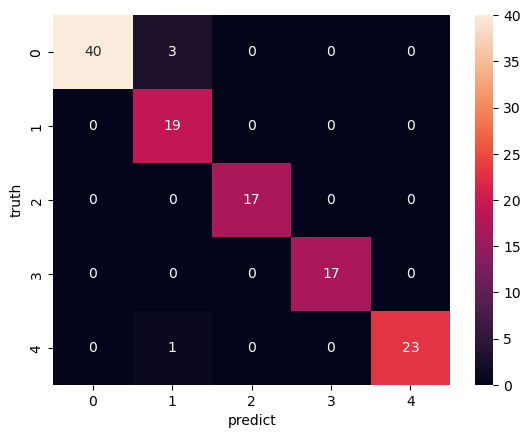

In [31]:
pred_test = estimator.predict(X2_test)
plot_confusion(label_test, pred_test)
plt.savefig('svc_test_confusion.png')

SVM-Regressor (Standardparameter)

In [32]:
regr = svm.SVR()
_= regr.fit(X2_train, festigkeit_train)

Vorhersage Trainingsdaten

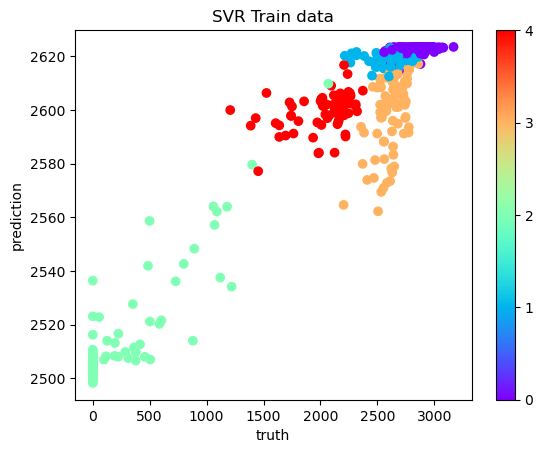

In [33]:
y_pred_train = regr.predict(X2_train)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.title('SVR Train data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('svr_train.png')

Vorhersage Testdaten

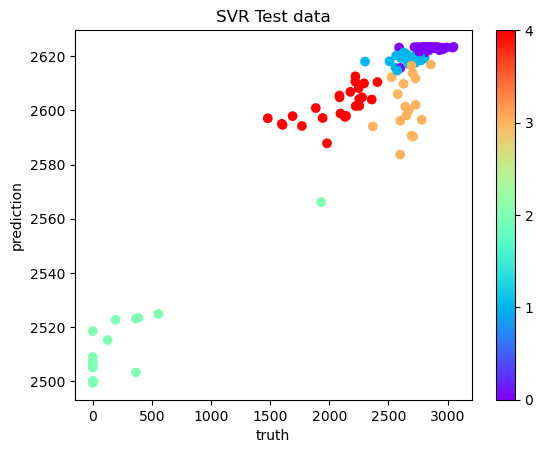

In [34]:
y_pred_test = regr.predict(X2_test)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('svr_test.png')

In [35]:
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")


MSE: train 996698.4, test: 861561.9
RMSE: train    998.3 test:    928.2
MAE: train    581.5, test:    537.7


Debug: Verteilung Festigkeiten

<Axes: ylabel='Frequency'>

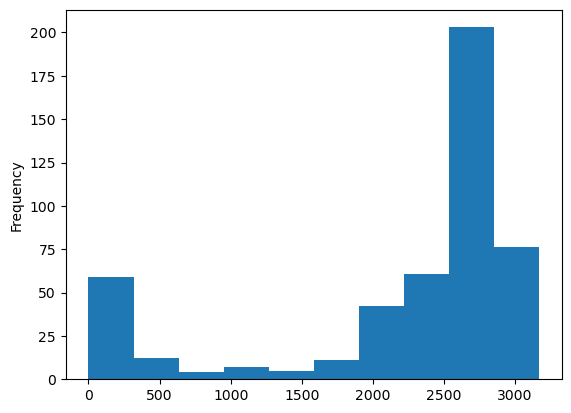

In [36]:
versuche_train.festigkeit.plot(kind='hist')

In [37]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'C': np.logspace(0, 4),      # 50 Werte zwischen 1 und 10000
    'gamma': np.logspace(-5, 1), # 50 Werte zwischen 1e-5 und 10
}
estim2 = model_selection.RandomizedSearchCV(
    svm.SVR(),
    params,
    n_iter=30,
)
estim2.fit(X2_train, festigkeit_train)
print('Best paramaters:', estim2.best_params_)
best_estim = estim2.best_estimator_


Best paramaters: {'gamma': 1.8420699693267164, 'C': 6866.488450042998}


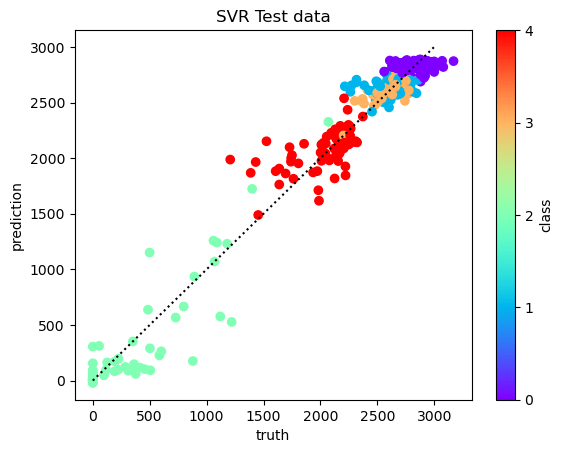

In [38]:
y_pred_train = best_estim.predict(X2_train)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
plt.savefig('svr_randsearch_train.png')

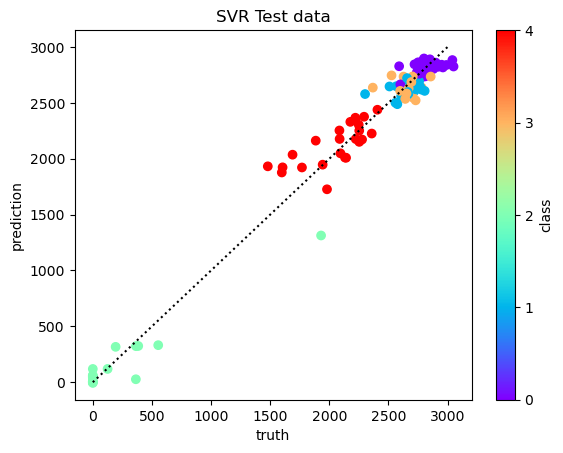

In [39]:
y_pred_test = best_estim.predict(X2_test)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
plt.savefig('svr_randsearch_test.png')

In [40]:
y_pred_train = best_estim.predict(X2_train)
y_pred_test = best_estim.predict(X2_test)
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")
# mapi ist nutzlos durch 0-Werte bei Zugfestigkeit
#mapi_train = metrics.mean_absolute_percentage_error(festigkeit_train, y_pred_train)
#mapi_test = metrics.mean_absolute_percentage_error(festigkeit_test, y_pred_test)
#print(f"MAPI: train {mapi_train:8.1f}, test: {mapi_test:8.1f}")



MSE: train  21851.2, test:  18952.5
RMSE: train    147.8 test:    137.7
MAE: train     98.4, test:     97.6


In [43]:
joblib.dump({
    'scaler': tsMaxScale,
    'svc': estimator,
    'svr': best_estim,
}, 'svr2.joblib')

['svr2.joblib']